## Classification Notes for Future Meeting (9/04/2024)
Notes for a future meeting - currently playing around with classification !

## Setup

In [3]:
import pathlib 
import pandas as pd 
from xgboost import XGBClassifier
from sklearn import metrics

import sys
sys.path.append(str(pathlib.Path.cwd().parents[0]/ "src" / "classify"))
from prepare_data import load_metrics, create_split
import seaborn as sns

In [4]:
path = pathlib.Path.cwd()

## Stories (Temp 1) Classification

In [5]:
# data 
datapath = path.parents[0] / "metrics"
stories1_df = load_metrics(datapath, dataset="stories", temp=1)

[INFO:] Loading data from human_metrics ...
[INFO:] Loading data from ai_metrics ...


In [6]:
clf = XGBClassifier(enable_categorical=True, use_label_encoder=False, random_state=129)

# all features
splits = create_split(stories1_df, random_state=129, val_test_size=0.15, outcome_col="is_human", verbose=False)

clf.fit(splits["X_train"], splits["y_train"])

# eval
y_pred = clf.predict(splits["X_val"])
print(metrics.classification_report(splits["y_val"], y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3000
           1       1.00      1.00      1.00      1500

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500



In [7]:
features = ["doc_length"]
splits = create_split(stories1_df, random_state=129,
                        val_test_size=0.15, 
                        outcome_col="is_human", 
                        verbose=False, feature_cols=features
                        )

clf.fit(splits["X_train"], splits["y_train"])

# eval
y_pred = clf.predict(splits["X_val"])
print(metrics.classification_report(splits["y_val"], y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3000
           1       0.86      0.67      0.75      1500

    accuracy                           0.85      4500
   macro avg       0.85      0.81      0.82      4500
weighted avg       0.85      0.85      0.85      4500



## Imbalanced Dataset? 

In [8]:
# define funtion to check imbalance from splits dict 
def check_imbalance(datapath):
    # create dict for saving imbalances
    imbalance = {}

    for dataset in ["stories", "mrpc", "dailydialog", "dailymail_cnn"]:
        df = load_metrics(datapath, dataset=dataset, temp=1)
        splits = create_split(df, random_state=129, val_test_size=0.15, outcome_col="is_human", verbose=False)
        
        # dict with counts for each split
        imbalance[dataset] = {'train': splits['y_train'].value_counts(),
                              'val': splits['y_val'].value_counts(),
                              'test': splits['y_test'].value_counts()}
        
    # convert to df 
    imbalance_df = pd.DataFrame.from_dict({(dataset, split): imbalance[dataset][split] for dataset in imbalance.keys() for split in imbalance[dataset].keys()}, orient='index')
    imbalance_df.index.names = ['Dataset', 'Split']
    imbalance_df.reset_index(inplace=True)

    return imbalance_df

In [9]:
imbalance_df = check_imbalance(datapath)
print(imbalance_df) # where 0 is ai and 1 is human

[INFO:] Loading data from human_metrics ...
[INFO:] Loading data from ai_metrics ...


[INFO:] Loading data from human_metrics ...
[INFO:] Loading data from ai_metrics ...
[INFO:] Loading data from human_metrics ...
[INFO:] Loading data from ai_metrics ...
[INFO:] Loading data from human_metrics ...
[INFO:] Loading data from ai_metrics ...
          Dataset  Split      0     1
0         stories  train  14000  7000
1         stories    val   3000  1500
2         stories   test   3000  1500
3            mrpc  train  10920  5460
4            mrpc    val   2340  1170
5            mrpc   test   2340  1170
6     dailydialog  train  14000  7000
7     dailydialog    val   3000  1500
8     dailydialog   test   3000  1500
9   dailymail_cnn  train   8400  4200
10  dailymail_cnn    val   1800   900
11  dailymail_cnn   test   1800   900


## Correlation Matrix

In [10]:
# filter irrelevant cols out
cols_to_drop = ["id", "unique_id", "sample_params", "temperature", "prompt_number", "contains_lorem ipsum"]
filtered_df = stories1_df.drop(cols_to_drop, axis=1)

In [11]:
corrM = filtered_df.corr()

/tmp/ipykernel_4677/3352751554.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrM = filtered_df.corr()


In [12]:
corrM

,alpha_ratio,automated_readability_index,coleman_liau_index,dependency_distance_mean,dependency_distance_std,doc_length,duplicate_line_chr_fraction,duplicate_ngram_chr_fraction_10,duplicate_ngram_chr_fraction_5,duplicate_ngram_chr_fraction_6,...,syllables_per_token_std,symbol_to_word_ratio_#,token_length_mean,token_length_median,token_length_std,top_ngram_chr_fraction_2,top_ngram_chr_fraction_3,top_ngram_chr_fraction_4,pos_prop_SPACE,is_human
alpha_ratio,1.000000,0.250282,0.247268,0.028181,-0.258554,-0.053632,-0.045862,-0.116648,-0.132379,-0.127308,...,0.133852,-0.156829,0.092716,0.033785,0.085531,-0.188584,-0.173473,-0.182353,-0.601964,-0.018365
automated_readability_index,0.250282,1.000000,0.797471,0.565801,-0.032386,0.224875,0.022653,0.025526,-0.019631,-0.014762,...,0.591638,-0.015551,0.634698,0.341759,0.519733,0.098334,0.152178,0.092150,-0.063826,-0.426761
coleman_liau_index,0.247268,0.797471,1.000000,0.255619,-0.059421,0.174112,-0.026298,-0.081222,-0.134642,-0.127455,...,0.756768,0.008269,0.917656,0.572254,0.680365,-0.048445,-0.017980,-0.058701,-0.186862,-0.339279
dependency_distance_mean,0.028181,0.565801,0.255619,1.000000,0.135385,0.222714,0.008699,0.191291,0.151805,0.157473,...,0.171294,-0.022432,0.057925,-0.041714,0.141553,0.354212,0.487318,0.464359,-0.157502,-0.313370
dependency_distance_std,-0.258554,-0.032386,-0.059421,0.135385,1.000000,0.343793,0.019530,0.136437,0.150504,0.143360,...,0.034384,-0.028072,-0.125903,-0.109217,0.030946,0.376623,0.363936,0.371837,0.247172,-0.073831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
top_ngram_chr_fraction_2,-0.188584,0.098334,-0.048445,0.354212,0.376623,0.186712,0.026579,0.253169,0.310051,0.277468,...,-0.027331,-0.014494,-0.096839,-0.090521,-0.018340,1.000000,0.691210,0.605511,0.083369,-0.150044
top_ngram_chr_fraction_3,-0.173473,0.152178,-0.017980,0.487318,0.363936,0.196874,0.026133,0.326737,0.389661,0.351222,...,-0.006598,-0.007867,-0.061903,-0.065886,0.003784,0.691210,1.000000,0.853527,0.074415,-0.153225
top_ngram_chr_fraction_4,-0.182353,0.092150,-0.058701,0.464359,0.371837,0.121919,0.038199,0.368392,0.426753,0.401245,...,-0.040215,0.000138,-0.080399,-0.060250,-0.021519,0.605511,0.853527,1.000000,0.095796,-0.070773
pos_prop_SPACE,-0.601964,-0.063826,-0.186862,-0.157502,0.247172,-0.140656,0.249116,0.141464,0.122825,0.131598,...,-0.106256,-0.001996,-0.163110,-0.080517,-0.074351,0.083369,0.074415,0.095796,1.000000,NaN


<Axes: >

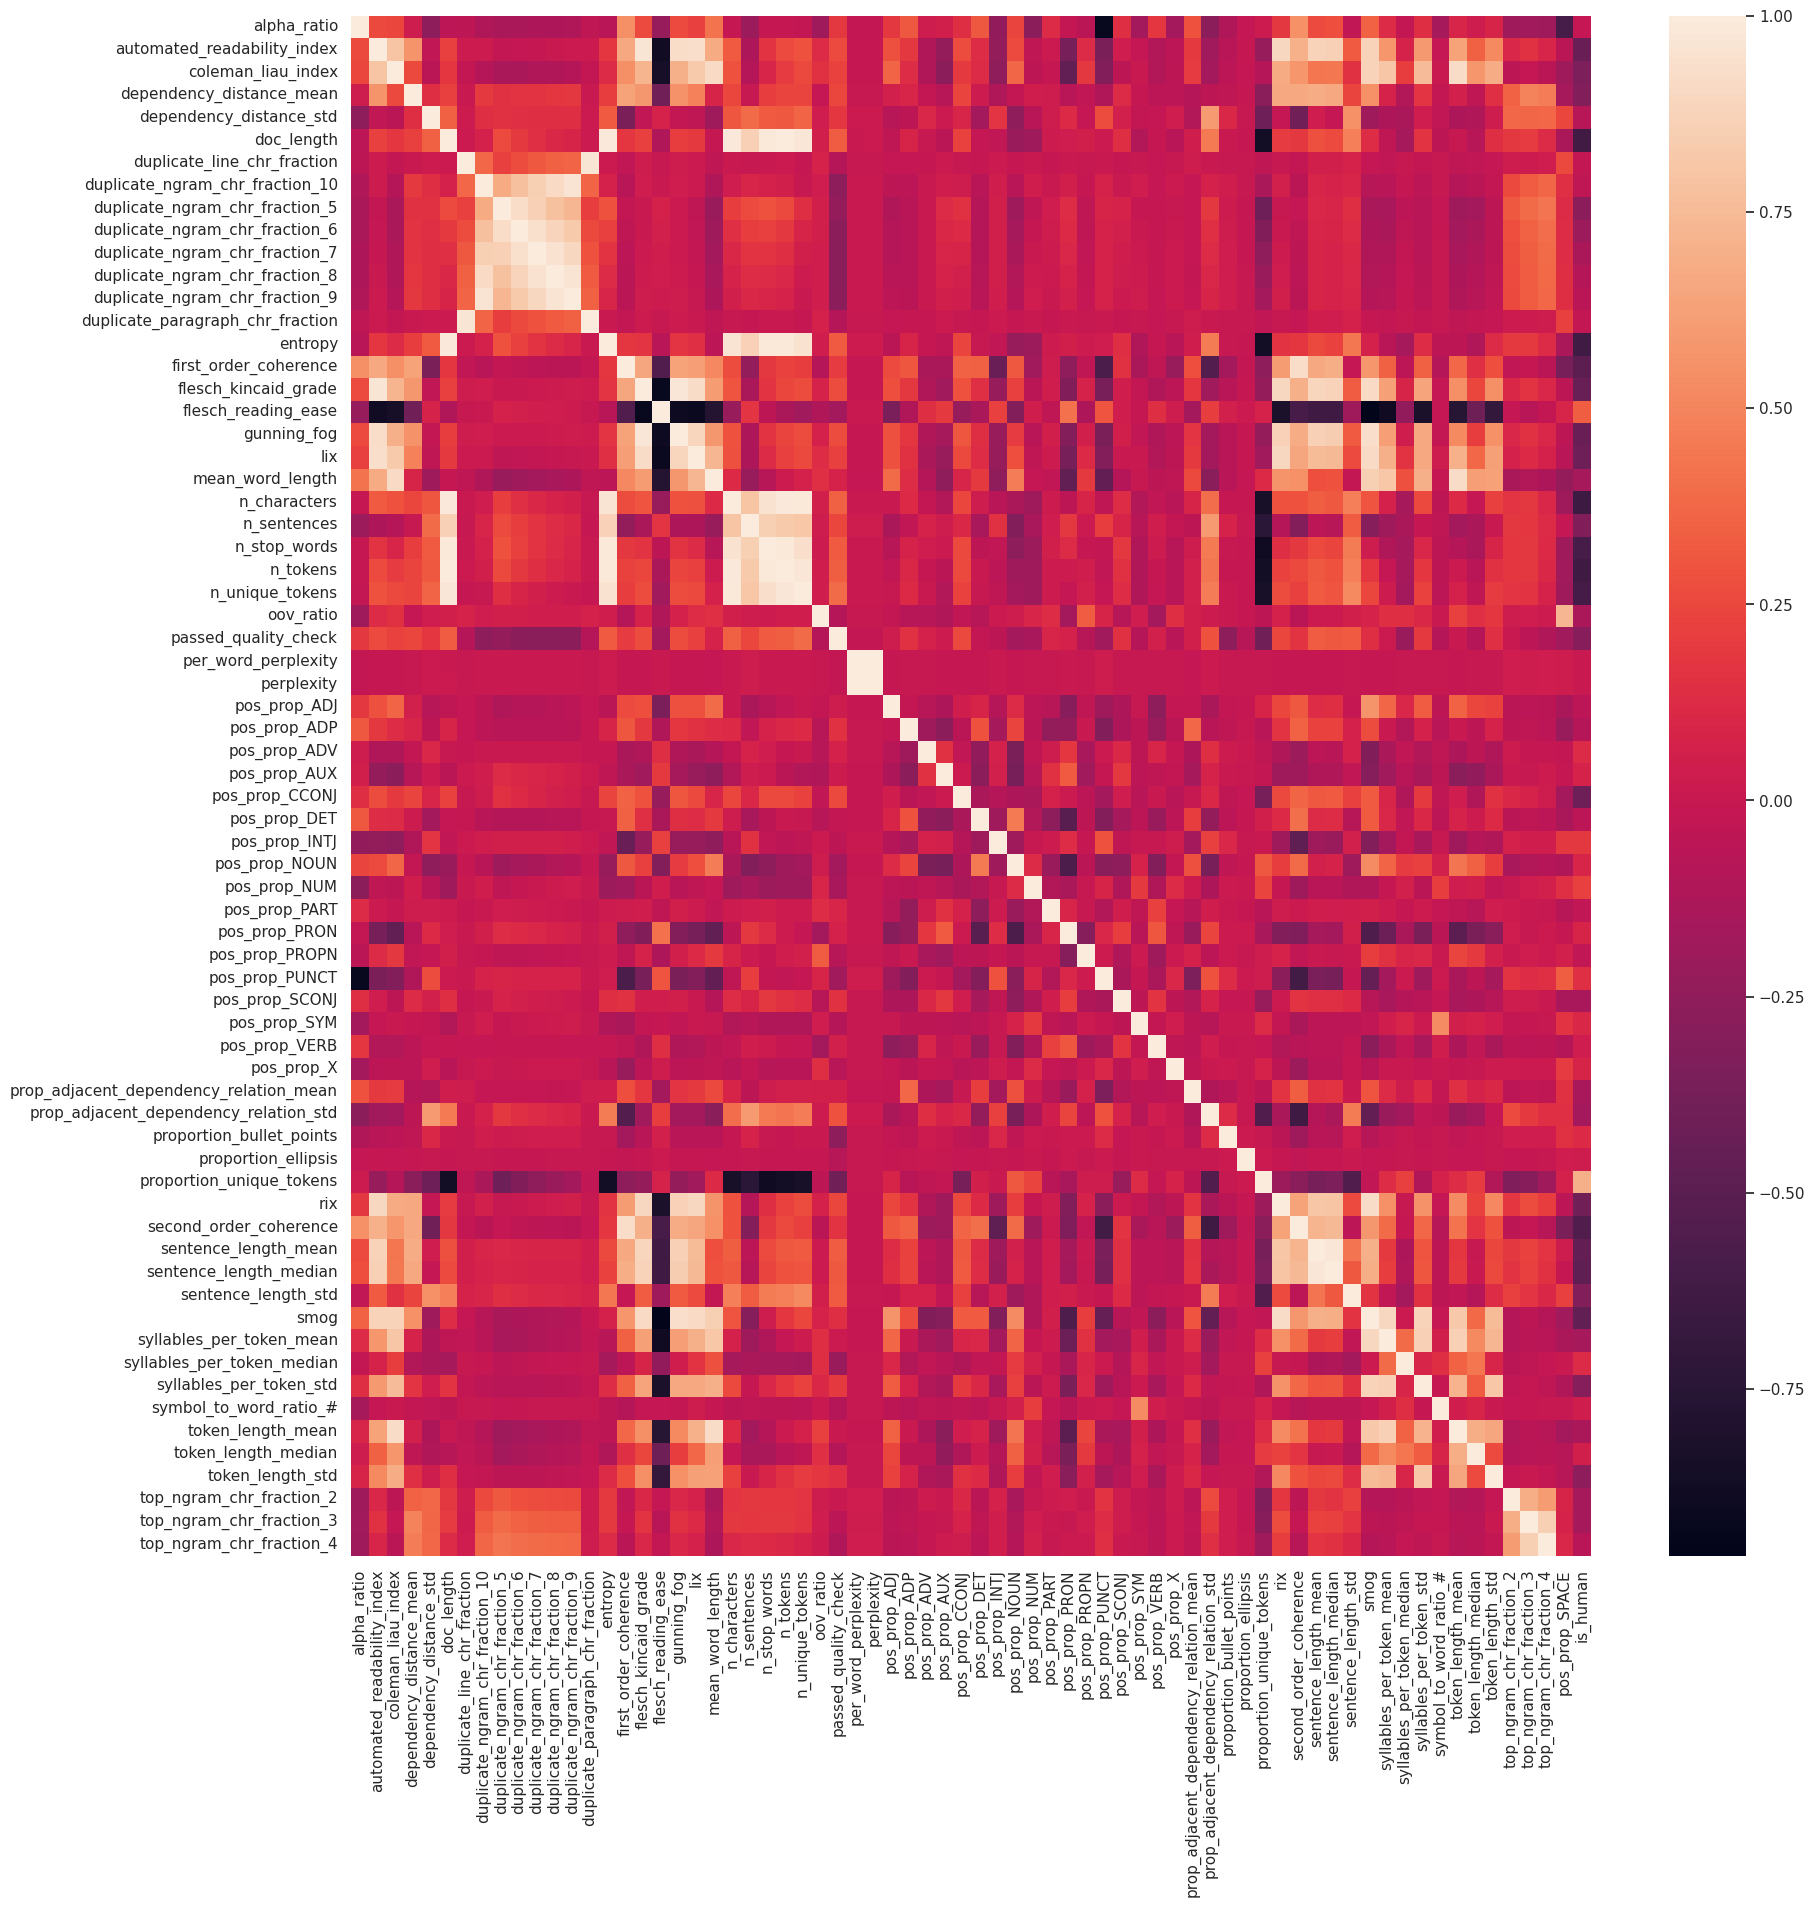

In [16]:
# drop nan
sns.set_theme(rc={'figure.figsize':(20, 20)})

# drop pos_prop_space as it is NA for is_human, then drop all other cols that is na (temporarily)
corrM = corrM.drop("pos_prop_space", axis=1)

sns.heatmap(corrM.dropna())